In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.style.use("seaborn")

## Modified model with VGG-19 Arhcitecture via Early-Exit block implementation on CIFAR + CIFAR-100 datasets
--------------------

### Ідея
Метою даної роботи є модернізація CNN з VGG-19 архітектурою шляхом впровадженя в неї EE-блоку та дослідження характеристик побудованої нейронної мережі на задачах класифікації зображень, а також порівняння результатів даної мережі з моделлю, яка реалізує VGG-19 архітектуру (див. рис.1), але без використання Early-Exit блоку.

### Розроблена модель
Для проведення досліджень за основу було використано архітектуру згорткової нейронної мережі VGG-19. У модель, у якій реалізовано таку архітектуру, після першого блоку в згортковій основі було додано користувацький EЕ-блок (див. рис.2). Його головна мета полягяє у відсіюванні надлишкових зображень на ранніх етапах обчислень, щоб зекономити ресурси моделі при класифікації необхідних зображень. Ефективна реалiзацiя такої моделі на практицi дає змогу в наперед визначених місцях обчислювального графа динамічно обирати шлях під час отримання результату.

EE-блок створений на основі шарів максимізаційного агрегування (MaxPooling) та повністю зв'язних шарів (Fully-Connected, Dense), структура яких аналогічна до шарів у VGG-19 архітектурі. Також цей блок складається з шару, який вирівнює форму результату попереднього шару (Flatten). Це зроблено з метою застосування на останньому етапі повністю зв'язного шару, який на виході буде давати результат розподілу ймовірностей бінарної класифікації за допомогою функції активації $softmax$. Саме на цьому етапі модель буде визначати, чи зображення належить до надлишкового класу зображень, які не потребують подальшої класифікації.

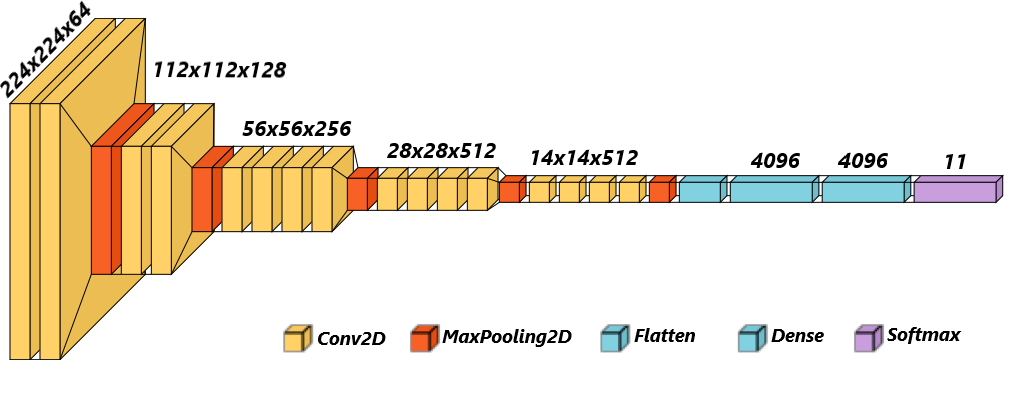
### *Рис.1: Модель на основі VGG-19 архітектури.*

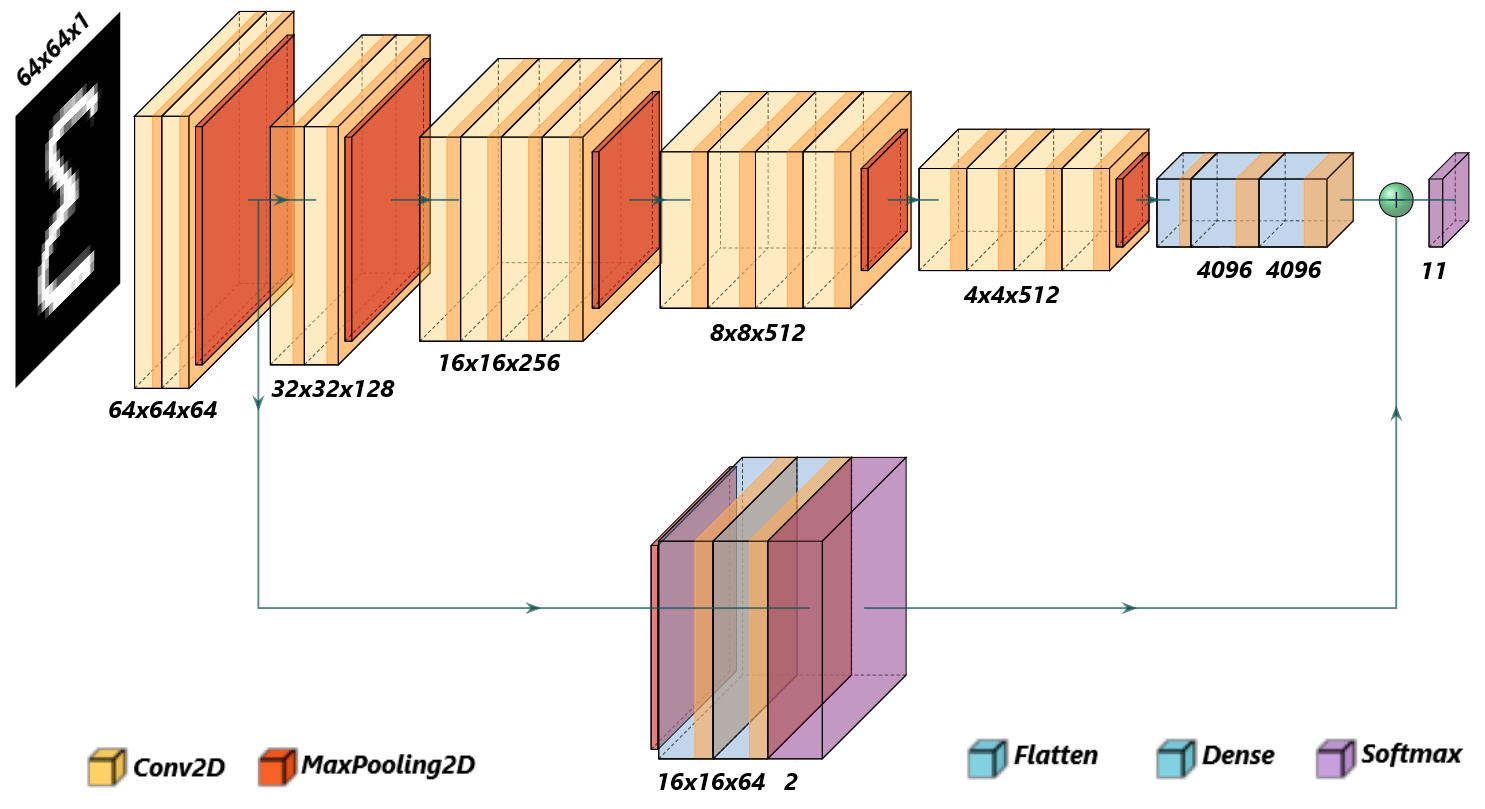
### *Рис.2: Модернізована модель на основі VGG-19 архітектури з реалізованим користувацьким EE-блоком.*

# Data preparation

## CIFAR-10

Набір даних CIFAR-10 містить 60000 зображень розміром 32х32 пікселі у форматі RGB з 10 різних класів ("літак" $\,$, "автомобіль" $\,$, "птах" $\,$, "кіт" $\,$, "олень" $\,$, "собака" $\,$, "жаба" $\,$, "кінь" $\,$, "корабель" $\,$, "вантажний автомобіль" $\,$). Множина тренувальних даних містить вього 50000 зображень, множина тестувальних даних -- 10000 зображень.

In [2]:
# Defined size for images for all datasets
img_height = 64
img_width = 64

In [3]:
def preprocess_cifar(X_cifar, X_cifar_test):
    X_cifar = X_cifar.astype('bfloat16')   #COMMENTED 04.02
    X_cifar_test = X_cifar_test.astype('bfloat16')
    
    # Normalize images for better processing (values in range [0; 1])
    X_cifar = X_cifar / 255
    X_cifar_test = X_cifar_test / 255
    
    # Resize images from 32x32 to 64x64 (returns EagerTensor type)
    X_cifar = tf.image.resize_with_pad(
        image=X_cifar,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )
    X_cifar_test = tf.image.resize_with_pad(
        image=X_cifar_test,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )

    # Convert EagerTensor to numpy array
    X_cifar = X_cifar.numpy()
    X_cifar_test = X_cifar_test.numpy()
    
    return X_cifar, X_cifar_test

In [4]:
(X_cifar, y_cifar), (X_cifar_test, y_cifar_test) = tf.keras.datasets.cifar10.load_data()

X_cifar, X_cifar_test = preprocess_cifar(X_cifar, X_cifar_test)

from IPython.display import clear_output
clear_output()

In [5]:
print(f"X_cifar shape: {X_cifar.shape}")
print(f"y_cifar shape: {y_cifar.shape}")
print(f"X_cifar_test shape: {X_cifar_test.shape}")
print(f"y_cifar_test shape: {y_cifar_test.shape}")

X_cifar shape: (50000, 64, 64, 3)
y_cifar shape: (50000, 1)
X_cifar_test shape: (10000, 64, 64, 3)
y_cifar_test shape: (10000, 1)


## CIFAR-100

Натомість набір даних CIFAR-100 також містить 60000 зображень розміром 32х32 пікселі у форматі RGB, з яких 50000 відведені для тренування, а 10000 -- для тестування моделі. Однак в даному випадку класифікація відбувається на 100 класів, тобто кожен клас містить 600 зображень. Кожен з цих класів, які також вважаються "спеціальними" $\,$ класами (fine labels), розподіляються між 20 "загальними" $\,$ суперкласами (coarse labels). Для проведення досліджень набір даних CIFAR-10 було використано у ролі головного. Натомість зображення з трьох суперкласів у CIFAR-100 датасеті, а саме "побутові електроприлади" $\,$ (household electrical devices), "харчові контейнери" $\,$ (food containers) та "побутові меблі" $\,$ (household furniture), було використано для відображення надлишкових даних. Кожен зі згаданих суперкласів містить зображення з 5 загальних класів. В результаті 9000 зображень, з яких 7500 для тренування та 1500 для тестування, виконували роль допоміжних при класифікації розглянутих моделей. Всі зображення з CIFAR-10 та CIFAR-100 датасетів під час препроцесингу були нормалізовані та перетворені у формат 64х64 пікселі.

In [6]:
(X_cifar100, y_cifar100), (X_cifar100_test, y_cifar100_test) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')

X_cifar100, X_cifar100_test = preprocess_cifar(X_cifar100, X_cifar100_test)

from IPython.display import clear_output
clear_output()

In [7]:
print(f"X_cifar100 shape: {X_cifar100.shape}")
print(f"y_cifar100 shape: {y_cifar100.shape}")
print(f"X_cifar100_test shape: {X_cifar100_test.shape}")
print(f"y_cifar100_test shape: {y_cifar100_test.shape}")

X_cifar100 shape: (50000, 64, 64, 3)
y_cifar100 shape: (50000, 1)
X_cifar100_test shape: (10000, 64, 64, 3)
y_cifar100_test shape: (10000, 1)


In [8]:
y_cifar100 = np.squeeze(y_cifar100)
y_cifar100_test = np.squeeze(y_cifar100_test)

In [9]:
# food containers, household electrical devices, household furniture as redundant data => 3 coarse classes => 15 fine classes with 600 images each => 9000
indeces_for_y_cifar100 = np.argwhere((y_cifar100 == 3) | (y_cifar100 == 5) | (y_cifar100 == 6))  
indeces_for_y_cifar100_test = np.argwhere((y_cifar100_test == 3) | (y_cifar100_test == 5) | (y_cifar100_test == 6))

indeces_for_y_cifar100 = np.squeeze(indeces_for_y_cifar100)
indeces_for_y_cifar100_test = np.squeeze(indeces_for_y_cifar100_test)

# change label of redundant data to 10 for future concatenation 
np.put_along_axis(y_cifar100, indeces_for_y_cifar100, 10, axis=0)        
np.put_along_axis(y_cifar100_test, indeces_for_y_cifar100_test, 10, axis=0)

X_cifar100 = np.take(X_cifar100, indeces_for_y_cifar100, axis=0)
y_cifar100 = np.take(y_cifar100, indeces_for_y_cifar100, axis=0)

X_cifar100_test = np.take(X_cifar100_test, indeces_for_y_cifar100_test, axis=0)
y_cifar100_test = np.take(y_cifar100_test, indeces_for_y_cifar100_test, axis=0)

In [10]:
print(f"X_cifar100 shape: {X_cifar100.shape}")
print(f"y_cifar100 shape: {y_cifar100.shape}")
print(f"X_cifar100_test shape: {X_cifar100_test.shape}")
print(f"y_cifar100_test shape: {y_cifar100_test.shape}")

X_cifar100 shape: (7500, 64, 64, 3)
y_cifar100 shape: (7500,)
X_cifar100_test shape: (1500, 64, 64, 3)
y_cifar100_test shape: (1500,)


# Subclassing implementation

### *Діаграма класів, використаних у поданій роботі*
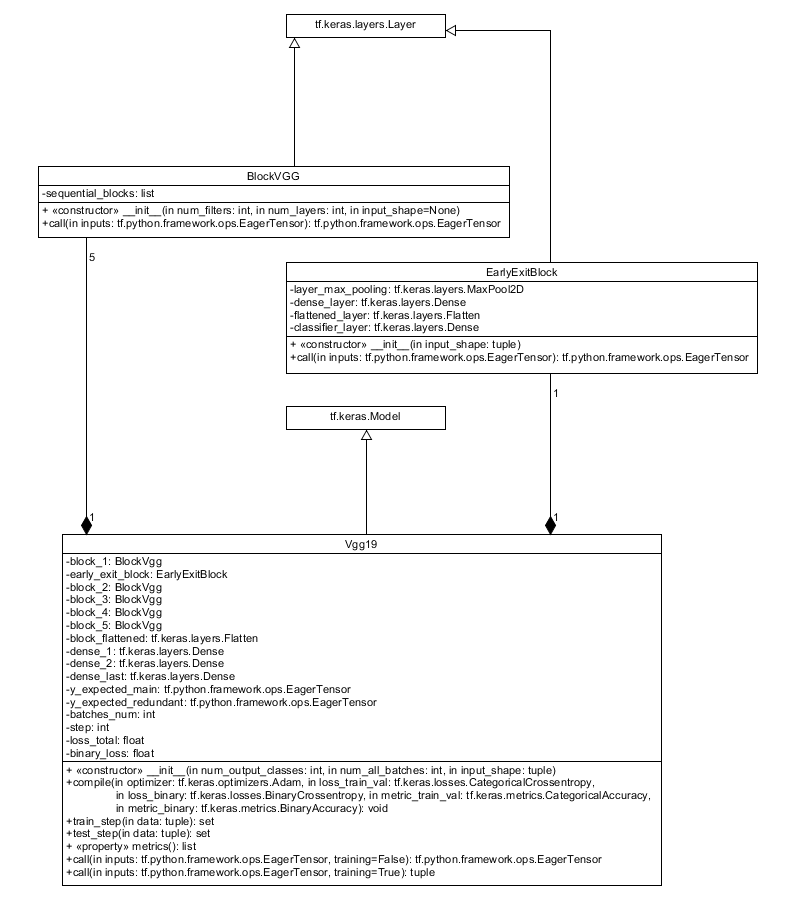

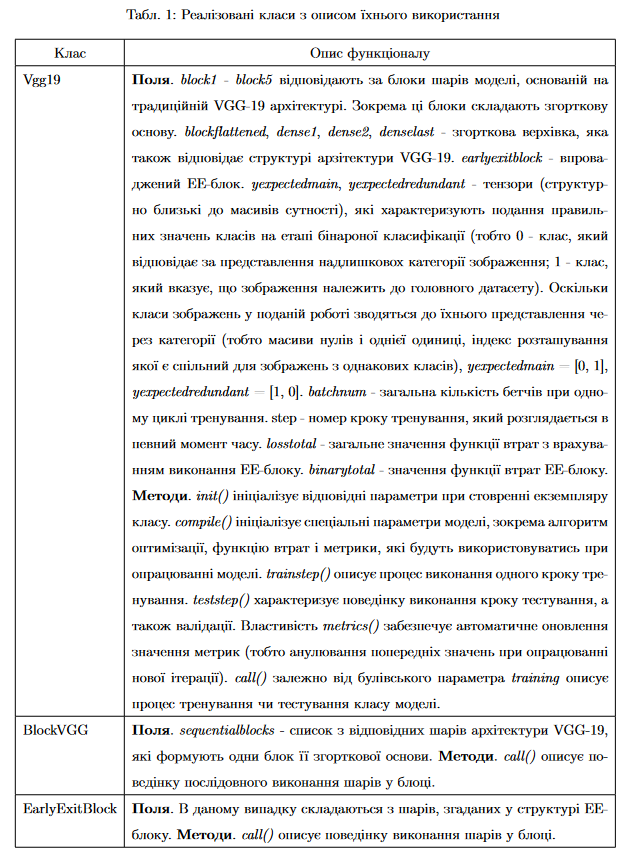

In [11]:
class BlockVgg(tf.keras.layers.Layer):
  def __init__(self, *, num_filters: int, num_layers: int, input_shape=None):
    super().__init__()
    self.sequential_blocks = []
    for num_layer in range(num_layers):
      if input_shape is not None:
        self.sequential_blocks.append(tf.keras.layers.Conv2D(filters=num_filters, input_shape=input_shape, kernel_size=(3, 3), padding='same', activation=tf.keras.layers.ReLU()))
      else:
        self.sequential_blocks.append(tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same', activation=tf.keras.layers.ReLU()))
    self.sequential_blocks.append(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
  
  def call(self, inputs):
    output = self.sequential_blocks[0](inputs)
    for layer in self.sequential_blocks[1:]:
      output = layer(output)
    
    return output


In [12]:
class EarlyExitBlock(tf.keras.layers.Layer):
  def __init__(self, input_shape):
    super().__init__()
    self.layer_max_pooling = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
    self.dense_layer = tf.keras.layers.Dense(64, activation=tf.keras.layers.ReLU())
    self.flattened_layer = tf.keras.layers.Flatten()
    self.classifier_layer = tf.keras.layers.Dense(2, activation=tf.keras.layers.Softmax())
  

  def call(self, inputs):
    output = self.layer_max_pooling(inputs)
    output = self.flattened_layer(output)
    output = self.dense_layer(output)
    output = self.classifier_layer(output)

    return output


In [13]:
class Vgg19(tf.keras.Model):
  def __init__(self, num_output_classes: int, input_shape) -> None:
    super().__init__()

    self.block_1 = BlockVgg(num_filters=64, num_layers=2, input_shape=input_shape)

    self.early_exit_block = EarlyExitBlock(input_shape=(input_shape[0]/2, 
                                                        input_shape[1]/2))

    self.block_2 = BlockVgg(num_filters=128, num_layers=2)
    self.block_3 = BlockVgg(num_filters=256, num_layers=4)
    self.block_4 = BlockVgg(num_filters=512, num_layers=4)
    self.block_5 = BlockVgg(num_filters=512, num_layers=4)
        
    self.block_flattened = tf.keras.layers.Flatten()

    self.dense_1 = tf.keras.layers.Dense(4096, activation=tf.keras.layers.ReLU())
    self.dense_2 = tf.keras.layers.Dense(4096, activation=tf.keras.layers.ReLU())
    self.dense_last = tf.keras.layers.Dense(num_output_classes, activation='softmax')
    
    # Variables for calculating loss
    self.NON_PHOTO = 0
    self.IS_PHOTO = 1

    self.y_expected_cifar = tf.one_hot([self.IS_PHOTO], 2)
    self.y_expected_cifar100 = tf.one_hot([self.NON_PHOTO], 2)
    
    self.step = 0
    self.loss_total = 0
    self.binary_loss = 0
    
    
    
  def compile(self, optimizer, loss_train_val, loss_binary, metric_train_val, metric_binary):
    super(Vgg19, self).compile()
    # Optimizer
    self.optimizer = optimizer

    # Losses
    self.compiled_loss = loss_train_val
    self.binary_crossentropy_loss = loss_binary

    # Metrics
    self.compiled_metrics = metric_train_val
    self.binary_acc_metric = metric_binary
    
    # Metrics for tracking losses
    self.loss_tracker_train = tf.keras.metrics.Mean()
    self.loss_tracker_val = tf.keras.metrics.Mean()
    self.loss_tracker_binary = tf.keras.metrics.Mean()
    
    
    
  # Train step used in .fit(X, y) 
  def train_step(self, data):     # should be (x, y)
    x_current_batch, y_current_batch = data
    
    with tf.GradientTape() as tape:

      # feed first cifar, then cifar100

      if self.step % 7 != 0:
        # print('cifar')

        early_exit_output_actual, classification_output_actual = self(x_current_batch, training=True)  # training true parameter
        output_expected = y_current_batch

        # 10 classes classification loss
        loss_classification = self.compiled_loss(output_expected, classification_output_actual)

        # early exit classification loss for cifar
        y_expected_cifar_batch = tf.repeat(self.y_expected_cifar, 64, axis=0)
        loss_early_exit = self.compiled_loss(y_expected_cifar_batch, early_exit_output_actual)

        # taking average of these losses in case this is PHOTO value
        self.loss_total = loss_classification + loss_early_exit
        
        # calculate binary loss within cifar (EE block result)
        self.binary_loss = self.binary_crossentropy_loss(y_expected_cifar_batch, early_exit_output_actual)

        # update training metric for cifar (EE + classification)
        self.compiled_metrics.update_state(y_expected_cifar_batch, early_exit_output_actual)
        self.compiled_metrics.update_state(output_expected, classification_output_actual)

        # update training metric for binary classification (EE)
        self.binary_acc_metric.update_state(y_expected_cifar_batch, early_exit_output_actual)

      else:
        # print('cifar100')

        early_exit_output_actual, classification_output_actual = self(x_current_batch, training=True)    # training true parameter
        output_expected = y_current_batch

        # in case of non-PHOTO class we don't calculate loss for 10 classes classification  part of network
        # this may produce warnings from tensorflow, check the names of the layers and if they are as expected, just ignore this warning

        y_expected_cifar100_batch = tf.repeat(self.y_expected_cifar100, 64, axis=0)
        loss_early_exit = self.compiled_loss(y_expected_cifar100_batch, early_exit_output_actual)

        # take loss only for early-exit block
        self.loss_total = loss_early_exit
        
        # calculate binary loss within cifar100 (EE block result)
        self.binary_loss = self.binary_crossentropy_loss(y_expected_cifar100_batch, early_exit_output_actual)

        # update training metric for cifar (only EE)
        self.compiled_metrics.update_state(y_expected_cifar100_batch, early_exit_output_actual)

        # update training metric for binary classification (EE)
        self.binary_acc_metric.update_state(y_expected_cifar100_batch, early_exit_output_actual)

    # choose correct weights here
    weights = self.trainable_weights

    gradients = tape.gradient(self.loss_total, weights)
    self.optimizer.apply_gradients(zip(gradients, weights))
    
    self.loss_tracker_train.update_state(self.loss_total)
    self.loss_tracker_binary.update_state(self.binary_loss)
    
    self.step += 1
    
    if (self.step == 718):
        self.step = 0

    return {"Training loss": self.loss_tracker_train.result(), "Training acc": self.compiled_metrics.result(), "Binary loss": self.loss_tracker_binary.result(), "Binary acc": self.binary_acc_metric.result()}



  def test_step(self, data):
    x_batch, y_batch = data
    
    # Compute predictions
    output_actual = vgg_19_test(x_batch, training=False)

    # Calculate validation loss
    val_loss = self.compiled_loss(y_batch, output_actual)
    self.loss_tracker_val.update_state(val_loss)

    # Update val metrics
    self.compiled_metrics.update_state(y_batch, output_actual)
    
    self.step = 0
    
    return {"Validation loss": self.loss_tracker_val.result(), "Validation acc": self.compiled_metrics.result()}


    
  @property
  def metrics(self):
    # `Metric` objects here so that `reset_states()` can be called automatically at the start of each epoch or at the start of `evaluate()`
    return [self.compiled_metrics, self.binary_acc_metric, self.loss_tracker_train, self.loss_tracker_val, self.loss_tracker_binary]

    

  def call(self, inputs, training=None):
    typical_output = self.block_1(inputs)

    early_exit_output = self.early_exit_block(typical_output)

    if not training:
        output_for_val_or_test = np.empty([inputs.shape[0], 11])
        
        anticipated_cifar_or_cifar100_result = np.argmax(early_exit_output, axis=1)     # 0 when NON_PHOTO; 1 when PHOTO
        indeces_for_cifar100 = np.argwhere(anticipated_cifar_or_cifar100_result == 0)
        indeces_for_cifar = np.argwhere(anticipated_cifar_or_cifar100_result == 1)
        
        if len(indeces_for_cifar100) > 0:
            # insert tensors defining cifar100 images for specific indeces, where cifar100 images were defined in EE
            np.put_along_axis(output_for_val_or_test, indeces_for_cifar100, tf.one_hot([10], 11), axis=0)
            
        if len(indeces_for_cifar) == 0:
            #print("indeces_for_cifar IS EMPTY")
            return output_for_val_or_test
        
        # modify mnsit indeces
        indeces_for_cifar = np.squeeze(indeces_for_cifar, axis=1)
        
        # take to classificstion step only those images which are from cifar
        typical_output = np.take(typical_output, indeces_for_cifar, axis=0)
        

    typical_output = self.block_2(typical_output)
    typical_output = self.block_3(typical_output)
    typical_output = self.block_4(typical_output)
    typical_output = self.block_5(typical_output)

    typical_output = self.block_flattened(typical_output)

    typical_output = self.dense_1(typical_output)
    typical_output = self.dense_2(typical_output)
    typical_output = self.dense_last(typical_output)

    if training:
        return early_exit_output, typical_output
    else:
        # modify cifar indeces back
        indeces_for_cifar = np.expand_dims(indeces_for_cifar, axis=1)
        
        # insert tensors defining cifar images for specific indeces, where cifar images were defined in full vgg-19 classification
        np.put_along_axis(output_for_val_or_test, indeces_for_cifar, typical_output, axis=0)
        
        return output_for_val_or_test

# Subclassing usage

In [14]:
NON_PHOTO = 0
IS_PHOTO = 1

y_expected_cifar = tf.one_hot([IS_PHOTO], 2)
y_expected_cifar100 = tf.one_hot([NON_PHOTO], 2)

print(f"y_expected_cifar: {y_expected_cifar}; y_expected_cifar100: {y_expected_cifar100}")

y_expected_cifar: [[0. 1.]]; y_expected_cifar100: [[1. 0.]]


In [15]:
X_cifar100.shape[0]

7500

In [16]:
X_cifar.shape[0]

50000

## Train/Test split of datasets 

In [17]:
# Train / test (validation) split of cifar
X_cifar_train, X_cifar_val, y_cifar_train, y_cifar_val = train_test_split(X_cifar, y_cifar, train_size=0.8, test_size=0.2, random_state=0)

In [18]:
y_cifar_val.shape

(10000, 1)

In [19]:
# Train / test (validation) split of cifar100
X_cifar100_train, X_cifar100_val, y_cifar100_train, y_cifar100_val = train_test_split(X_cifar100, y_cifar100, train_size=0.8, test_size=0.2, random_state=0)

In [20]:
y_cifar100_train.shape

(6000,)

### Concatenation of cifar and cifar100 datasets for validation and testing step

In [21]:
y_cifar_val = np.squeeze(y_cifar_val)
y_cifar_test = np.squeeze(y_cifar_test)

X_cifar_cifar100_val = np.concatenate((X_cifar_val, X_cifar100_val), axis=0)
y_cifar_cifar100_val = np.concatenate((y_cifar_val, y_cifar100_val), axis=0)

X_cifar_cifar100_test = np.concatenate((X_cifar_test, X_cifar100_test), axis=0)
y_cifar_cifar100_test = np.concatenate((y_cifar_test, y_cifar100_test), axis=0)

# Shuffle concatenated validation and testing features and targets simultaneously
X_cifar_cifar100_val, y_cifar_cifar100_val = shuffle(X_cifar_cifar100_val, y_cifar_cifar100_val)
X_cifar_cifar100_test, y_cifar_cifar100_test = shuffle(X_cifar_cifar100_test, y_cifar_cifar100_test)

In [22]:
# 11 classes for validation and testing targets
y_cifar_cifar100_val = tf.keras.utils.to_categorical(y_cifar_cifar100_val)
y_cifar_cifar100_test = tf.keras.utils.to_categorical(y_cifar_cifar100_test)

In [23]:
print(f'Validation: X={X_cifar_cifar100_val.shape}, y={y_cifar_cifar100_val.shape}')
print(f'Test: X={X_cifar_cifar100_test.shape}, y={y_cifar_cifar100_test.shape}')

Validation: X=(11500, 64, 64, 3), y=(11500, 11)
Test: X=(11500, 64, 64, 3), y=(11500, 11)


## Merge cifar and cifar100 datasets for training in right order

In [24]:
# For training
bs = 64
num_batches_cifar = int(X_cifar_train.shape[0]/bs)
num_batches_cifar100 =  int(X_cifar100_train.shape[0]/bs)

X_cifar100_train = X_cifar100_train[:num_batches_cifar100 * bs]
y_cifar100_train = y_cifar100_train[:num_batches_cifar100 * bs]

times_datasets_differ_in = int(num_batches_cifar/num_batches_cifar100)

In [25]:
num_batches_cifar, num_batches_cifar100, times_datasets_differ_in

(625, 93, 6)

In [26]:
X_cifar_train_reshape = np.reshape(X_cifar_train, (num_batches_cifar, bs, 64,64,3)) 
X_cifar_train_reshape.shape

(625, 64, 64, 64, 3)

In [27]:
X_cifar100_train_reshape = np.reshape(X_cifar100_train, (num_batches_cifar100, bs, 64,64,3)) 
X_cifar100_train_reshape.shape

(93, 64, 64, 64, 3)

In [28]:
X_cifar_cifar100_train = np.insert(X_cifar_train_reshape, np.arange(0, num_batches_cifar100*times_datasets_differ_in, times_datasets_differ_in), X_cifar100_train_reshape, axis=0)

In [29]:
y_cifar_train_reshape = np.reshape(y_cifar_train, (num_batches_cifar, bs)) 
y_cifar_train_reshape.shape

(625, 64)

In [30]:
y_cifar100_train_reshape = np.reshape(y_cifar100_train, (num_batches_cifar100, bs)) 
y_cifar100_train_reshape.shape

(93, 64)

In [31]:
y_cifar_cifar100_train = np.insert(y_cifar_train_reshape, np.arange(0, num_batches_cifar100*times_datasets_differ_in, times_datasets_differ_in), y_cifar100_train_reshape, axis=0)

In [32]:
X_cifar_cifar100_train.shape

(718, 64, 64, 64, 3)

In [33]:
# 11 classes for training targets as well
y_cifar_cifar100_train = tf.keras.utils.to_categorical(y_cifar_cifar100_train)

In [34]:
y_cifar_cifar100_train.shape

(718, 64, 11)

In [35]:
# MAKE SHAPE (..., 64,64,1)
X_cifar_cifar100_train = np.reshape(X_cifar_cifar100_train, ((num_batches_cifar100+num_batches_cifar)*bs,64,64,3)) 
X_cifar_cifar100_train.shape

(45952, 64, 64, 3)

In [36]:
# MAKE SHAPE (..., 11)
y_cifar_cifar100_train = np.reshape(y_cifar_cifar100_train, ((num_batches_cifar100+num_batches_cifar)*bs,11)) 
y_cifar_cifar100_train.shape

(45952, 11)

In [37]:
num_batches_cifar

625

In [38]:
num_batches_cifar100

93

In [39]:
X_cifar_cifar100_train.shape

(45952, 64, 64, 3)

## Training and Evaluation

In [40]:
vgg_19_test = Vgg19(11, (img_height, img_width, 3))

In [41]:
vgg_19_test.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
                    loss_train_val=tf.keras.losses.CategoricalCrossentropy(),
                    loss_binary=tf.keras.losses.BinaryCrossentropy(),
                    metric_train_val=tf.keras.metrics.CategoricalAccuracy(),
                    metric_binary=tf.keras.metrics.BinaryAccuracy())

In [42]:
tf.config.run_functions_eagerly(True)

history_vgg_19_test = vgg_19_test.fit(
    X_cifar_cifar100_train, y_cifar_cifar100_train,
    validation_data=(X_cifar_cifar100_val, y_cifar_cifar100_val),
    batch_size=64,
    epochs=5,
    steps_per_epoch=num_batches_cifar+num_batches_cifar100,
    shuffle=False
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/5
718/718 [==============================] - 124s 153ms/step - Training loss: 2.4738 - Training acc: 0.4927 - Binary loss: 0.4652 - Binary acc: 0.8286 - val_Validation loss: 2.8428 - val_Validation acc: 0.0860
Epoch 2/5
718/718 [==============================] - 110s 153ms/step - Training loss: 2.3161 - Training acc: 0.5160 - Binary loss: 0.3829 - Binary acc: 0.8529 - val_Validation loss: 2.5523 - val_Validation acc: 0.2149
Epoch 3/5
718/718 [==============================] - 101s 141ms/step - Training loss: 1.9316 - Training acc: 0.5977 - Binary loss: 0.3447 - Binary acc: 0.8634 - val_Validation loss: 2.4841 - val_Validation acc: 0.2667
Epoch 4/5
718/718 [==============================] - 101s 140ms/step - Training loss: 1.7132 - Training acc: 0.6442 - Binary loss: 0.3185 - Binary acc: 0.8725 - val_Validation loss: 2.2043 - val_Validation acc: 0.3870
Epoch 5/5
718/718 [==============================] - 100s 139ms/step - Training loss: 1.5311 - Training acc: 0.6866 - Binary los

In [43]:
score_cifar100_cifar = vgg_19_test.evaluate(X_cifar_cifar100_test, y_cifar_cifar100_test)
print('Test loss:', score_cifar100_cifar[1])
print('Test score:', score_cifar100_cifar[0])

print("CNN Error: %.2f%%" % (100-score_cifar100_cifar[0]*100))

360/360 [==============================] - 14s 39ms/step - Validation loss: 2.0596 - Validation acc: 0.4459
Test loss: 2.090926170349121
Test score: 0.44973912835121155
CNN Error: 55.03%


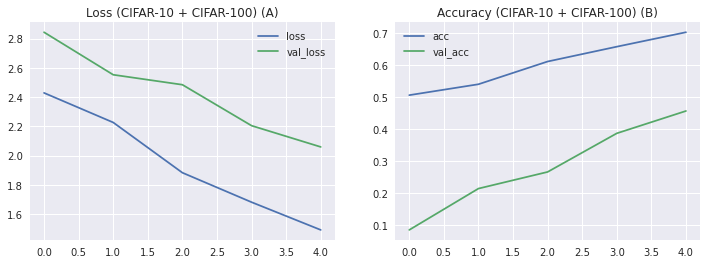

In [44]:
history_vgg_19_test_frame = pd.DataFrame(history_vgg_19_test.history)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg_19_test_frame['Training loss'], label='loss')
plt.plot(history_vgg_19_test_frame['val_Validation loss'], label='val_loss')
plt.title('Loss (CIFAR-10 + CIFAR-100) (A)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg_19_test_frame['Training acc'], label='acc')
plt.plot(history_vgg_19_test_frame['val_Validation acc'], label='val_acc')
plt.title('Accuracy (CIFAR-10 + CIFAR-100) (B)')
plt.legend()

## Prediction, inference time, confusion matrix

In [45]:
# GPU T4 x2, batch_size = 32 (default)
start_time = time.time()

#Predict y_test values for comparison in confusion matrix (cifar100 + cifar, 11 classes)
y_test_pred = vgg_19_test.predict(X_cifar_cifar100_test)

elapsed = time.time() - start_time

y_test_true = y_cifar_cifar100_test

In [46]:
print(f"Inference time for all samples (batch_size=64) : {np.round(elapsed, 6)} sec.\nAverage inference time for 1 sample (cifar100 + cifar dataset, 11 classes): {np.round(elapsed / len(X_cifar_cifar100_test), 6)} sec.")

Inference time for all samples (batch_size=64) : 10.517216 sec.
Average inference time for 1 sample (cifar100 + cifar dataset, 11 classes): 0.000915 sec.


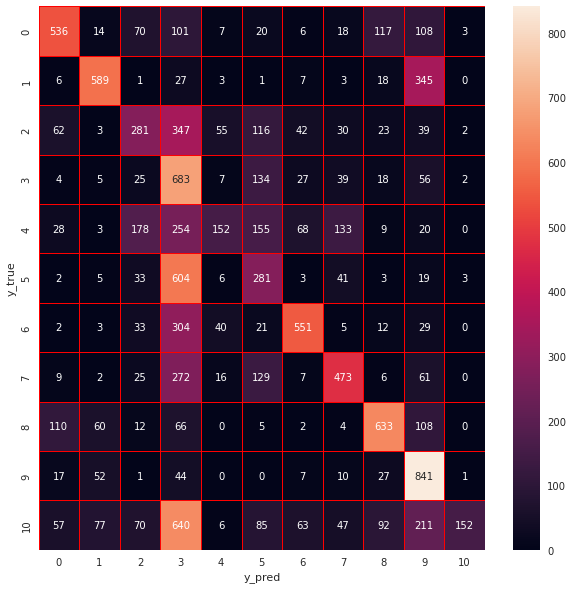

In [49]:
#Confusion matrix for cifar + cifar100 evaluation data
cifar100_cifar_cm=confusion_matrix(y_test_true.argmax(axis=1), y_test_pred.argmax(axis=1))

f, ax=plt.subplots(figsize=(10,10))
sns.heatmap(cifar100_cifar_cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### Other metrics nad results

In [50]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
labels.append("Household")

def plot_image(i, predictions_array, true_array, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_array):
    plt.grid(False)
    plt.xticks(range(11))
    plt.yticks([])
    thisplot = plt.bar(range(11), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

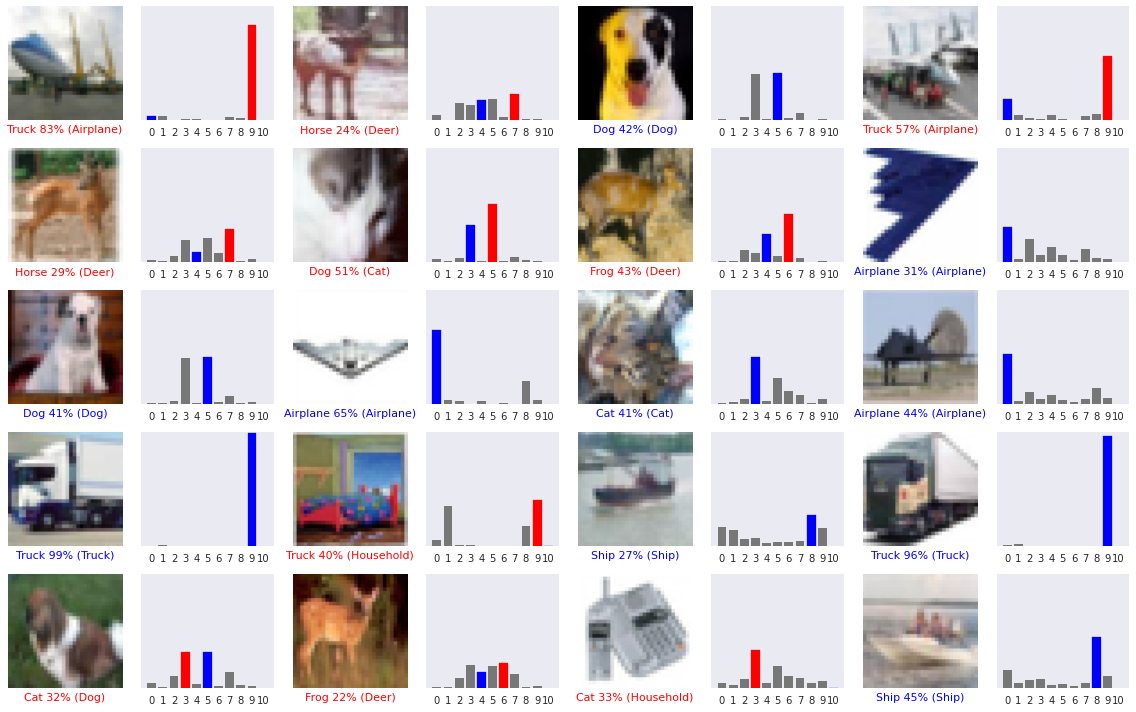

In [51]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
X_cifar_cifar100_test = X_cifar_cifar100_test.astype("float32")
num_rows = 5
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, y_test_pred[i+20], y_test_true[i+20], X_cifar_cifar100_test[i+20])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_test_pred[i+20], y_test_true[i+20])
plt.tight_layout()
plt.show()